In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Analyzing Zip decompression

Points of interest to analyze:
 - What is the relationship between compressed and decompressed size?
 - Files/folders compressed in zip files have metadata about uncompressed size. How accurate is this?
 - What are the file extensions of the decompressed files?
 - How much of an improvement is estimation vs. decompression?

**Note: Estimation
refers to utilizing the `ZipInfo` object from the `zipfile` library to retrieve uncompressed file size from file headers** 

In [73]:
# Import decompression size .csv
zip_batch_1_df = pd.read_csv("data/zip_batch_1_results.csv")

# Import decompressed files
zip_batch_1_decompressed_files = []
with open("data/zip_batch_1_decompressed_files.txt") as f:
    for line in f:
        zip_batch_1_decompressed_files.append(line.rstrip("\n"))

In [78]:
# Summarise data
print(f"{zip_batch_1_df.describe()}\n")

print(f"{len(zip_batch_1_df.index)} files decompressed into {len(zip_batch_1_decompressed_files)} files\n")
print(f"Compression types: {set(zip_batch_1_df.compression_type)}\n")

       compressed_size  decompressed_size  predicted_value  compression_type  \
count     4.710000e+02       4.710000e+02     4.710000e+02        471.000000   
mean      1.054718e+07       3.833339e+07     3.833339e+07          7.949045   
std       1.051166e+07       5.494940e+07     5.494940e+07          0.637110   
min       4.451000e+03       2.552500e+04     2.552500e+04          0.000000   
25%       1.999088e+06       4.861736e+06     4.861736e+06          8.000000   
50%       6.544374e+06       1.461584e+07     1.461584e+07          8.000000   
75%       1.730350e+07       4.052756e+07     4.052756e+07          8.000000   
max       4.097834e+07       2.488332e+08     2.488332e+08          8.000000   

       decompression_time  prediction_time  
count          471.000000       471.000000  
mean             0.195727         0.000316  
std              0.250205         0.000537  
min              0.001171         0.000089  
25%              0.032086         0.000139  
50%      

Text(0, 0.5, 'Decompressed size (bytes)')

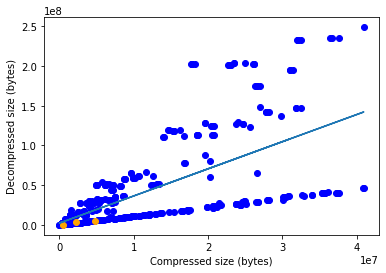

In [114]:
# Visualize compression vs. decompression
x1 = zip_batch_1_df.compressed_size
y1 = zip_batch_1_df.decompressed_size

# Figure 1
coef = np.polyfit(x1, y1, 1)
poly_fn1 = np.poly1d(coef)
plt.scatter(zip_batch_1_df[zip_batch_1_df.compression_type==8].compressed_size, 
            zip_batch_1_df[zip_batch_1_df.compression_type==8].decompressed_size,
            color="blue")
plt.scatter(zip_batch_1_df[zip_batch_1_df.compression_type==0].compressed_size, 
            zip_batch_1_df[zip_batch_1_df.compression_type==0].decompressed_size,
            color="orange")
plt.plot(x1, poly_fn1(x1))

plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")

Text(0, 0.5, 'Number of files')

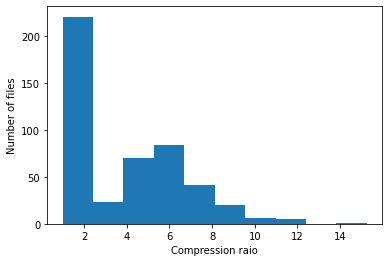

In [115]:
# Visualize compression ratios
compression_ratios = zip_batch_1_df.decompressed_size / zip_batch_1_df.compressed_size

# Figure 2
plt.hist(compression_ratios)

plt.xlabel("Compression raio")
plt.ylabel("Number of files")

Best fit line: 1.0000000000000002x + 5.492874116707939e-09


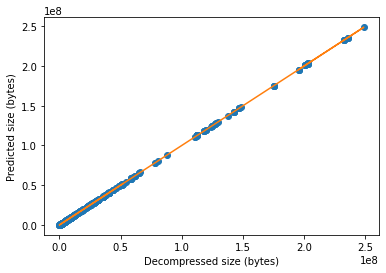

In [116]:
# Visualize actual decompression size vs. predicted size
x2 = zip_batch_1_df.decompressed_size
y2 = zip_batch_1_df.estimated_value

coef = np.polyfit(x2, y2, 1)
poly_fn2 = np.poly1d(coef)

# Figure 3
plt.plot(x2, y2,"o", x2,  
         poly_fn2(x2))

plt.xlabel("Decompressed size (bytes)")
plt.ylabel("Predicted size (bytes)")

print(f"Best fit line: {coef[0]}x + {coef[1]}")

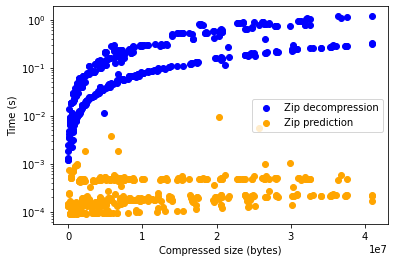

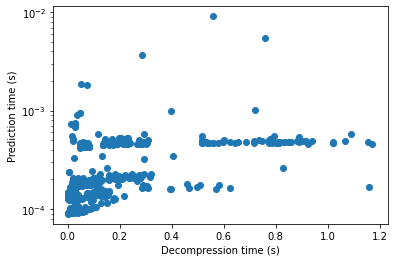

In [117]:
# Visualize compressed size vs. decompression time

x3 = zip_batch_1_df.compressed_size
y3 = zip_batch_1_df.decompression_time
y3_2 = zip_batch_1_df.estimation_time

# Figure 4
plt.scatter(x3, y3, color="blue", label="Zip decompression")
plt.scatter(x3, y3_2, color="orange", label="Zip prediction")

plt.xlabel("Compressed size (bytes)")
plt.ylabel("Time (s)")
plt.legend()
plt.yscale("log")
plt.show()

# Figure 5
plt.scatter(y3, y3_2)
plt.xlabel("Decompression time (s)")
plt.ylabel("Prediction time (s)")
plt.yscale("log")

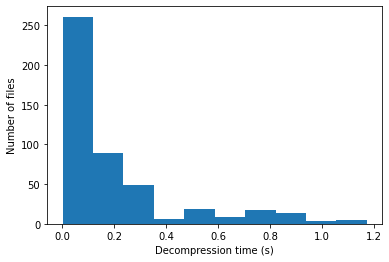

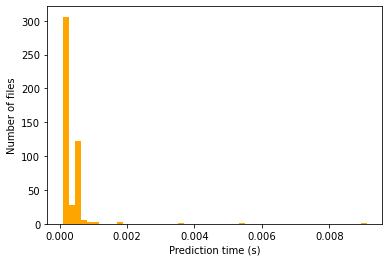

In [119]:
# Visualize decompression and prediction time distributions

# Figure 6
plt.hist(y3)

plt.ylabel("Number of files")
plt.xlabel("Decompression time (s)")
plt.show()

# Figure 7
plt.hist(y3_2, bins=50, color="orange")

plt.ylabel("Number of files")
plt.xlabel("Prediction time (s)")
plt.show()

## Analysis Results:
- The relationship between compressed size and decompressed size looks to be **highly linear**. From Figure 1, we can see that plotting these two values results in two distinct and highly linearly lines. It is still unclear why there are two distinct lines, but it seems unrelated to the compression type of the file.
- A large majority of the files have a ~2:1 ratio (the less steep line in Figure 1)
- Estimation is a **100%** accurate method for determining the final size of decompressed zip files. Figure 3 shows that the the equation of estimated decompressed size vs. true decompressed size is y=x.
- As shown by Figure 4, estimation is **orders of magnitude faster** than decompression. It is also interesting to note that when Figure 4 does not use a log scale for its axis, the decompression times highly resembles Figure 1.
- From Figures 4 and 5, we can see that estimation time has **no correlation** with decompression time and compressed file size.

## Conclusion:
The relationship between the comprsesed and decompressed size of zip files is highly linear. Further analysis could potentially yield multiple linear regressors which are capable of estimating the decompressed size of zip files. However, simply estimating the decompressed size using `ZipInfo` is far more accurate and much faster.